# Transformer Network Application: Question Answering

Welcome to Week 4's third, and the last lab of the course! Congratulations on making it this far. In this notebook you'll explore another application of the transformer architecture that you built.

**After this assignment you'll be able to**:

* Perform extractive Question Answering 
* Fine-tune a pre-trained transformer model to a custom dataset
* Implement a QA model in TensorFlow and PyTorch

## Table of Contents


- [1 - Extractive Question Answering](#1)
    - [1.1 - Data Cleaning](#1-1)
    - [1.2 - Tokenize and Align Labels with 🤗 Library](#1-2)
- [2 - Training](#2)
    - [2.1 TensorFlow implementation](#2-1)
    - [2.2 PyTorch implementation](#2-2)


<a name='1'></a>
## 1 - Extractive Question Answering

Question answering (QA) is a task of natural language processing that aims to automatically answer questions. The goal of *extractive* QA is to identify the portion of the text that contains the answer to a question. For example, when tasked with answering the question 'When will Jane go to Africa?' given the text data 'Jane visits Africa in September', the question answering model will highlight 'September'.

* You will use a variation of the Transformer model you built in the last assignment to answer questions about stories.
* You will implement extractive QA model in TensorFlow and in PyTorch.

**Recommendation:**
* If you are interested, check out the [Course 4: Natural Language Processing with Attention Models](https://www.coursera.org/learn/attention-models-in-nlp/home/welcome) of our [Natural Language Processing Specialization](https://www.coursera.org/specializations/natural-language-processing?=) where you can learn how to build Transformers and perform QA using the [Trax](https://trax.readthedocs.io/en/latest/) library. 

<a name='1-1'></a>
### 1.1 - Data preprocessing

Run the following cell to load the [QA bAbI dataset](https://research.fb.com/downloads/babi/), which is one of the bAbI datasets generated by Facebook AI Research to advance natural language processing.

In [1]:
from datasets import load_from_disk

# Load a dataset and print the first example in the training set
babi_dataset = load_from_disk('data/')
print(babi_dataset['train'][0])

{'story': {'answer': ['', '', 'office'], 'id': ['1', '2', '3'], 'supporting_ids': [[], [], ['1']], 'text': ['The office is north of the kitchen.', 'The garden is south of the kitchen.', 'What is north of the kitchen?'], 'type': [0, 0, 1]}}


Take a look at the format of the data. For a given story, there are two sentences which serve as the context, and one question. Each of these phrases has an ID. There is also a supporting fact ID which refers to a sentence in the story that helps answer the question. For example, for the question 'What is east of the hallway?', the supporting fact 'The bedroom is east of the hallway' has the ID '2'. There is also the answer, 'bedroom' for the question.

In [2]:
babi_dataset['train'][102]

{'story': {'answer': ['', '', 'bedroom'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['2']],
  'text': ['The bedroom is west of the office.',
   'The bedroom is east of the hallway.',
   'What is east of the hallway?'],
  'type': [0, 0, 1]}}

Check and see if the entire dataset of stories has this format.

In [3]:
type_set = set()
for story in babi_dataset['train']:
    if str(story['story']['type'] )not in type_set:
        type_set.add(str(story['story']['type'] ))

In [4]:
type_set

{'[0, 0, 1]'}

To make the data easier to work with, you will flatten the dataset to transform it from a dictionary structure to a table structure.

In [5]:
flattened_babi = babi_dataset.flatten()

In [6]:
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [7]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

Now it is much easier to access the information you need! You can now easily extract the answer, question, and facts from the story, and also join the facts into a single entry under 'sentences'.

In [8]:
def get_question_and_facts(story):
    dic = {}
    dic['question'] = story['story.text'][2]
    dic['sentences'] = ' '.join([story['story.text'][0], story['story.text'][1]])
    dic['answer'] = story['story.answer'][2]
    return dic

In [9]:
processed = flattened_babi.map(get_question_and_facts)

In [10]:
processed['train'][2]

{'answer': 'bedroom',
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1]}

In [11]:
processed['test'][2]

{'answer': 'bathroom',
 'question': 'What is north of the garden?',
 'sentences': 'The bathroom is north of the garden. The hallway is north of the bathroom.',
 'story.answer': ['', '', 'bathroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The bathroom is north of the garden.',
  'The hallway is north of the bathroom.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1]}

The goal of extractive QA is to find the part of the text that contains the answer to the question. You will identify the position of the answer using the indexes of the string. For example, if the answer to some question was 'September', you would need to find the start and end string indices of the word 'September' in the context sentence 'Jane visits Africa in September.'


Use this next function to get the start and end indices of the answer in each of the stories in your dataset.

In [12]:
def get_start_end_idx(story):
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])
    return {'str_idx':str_idx,
          'end_idx': end_idx}

In [13]:
processed = processed.map(get_start_end_idx)

In [14]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'answer': 'garden', 'end_idx': 34, 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'str_idx': 28}
answer: garden


<a name='1-2'></a>
### 1.2 - Tokenize and Align with 🤗 Library

Now you have all the data you need to train a Transformer model to perform Question Answering! You are ready for a task you may have already encountered in the Named-Entity Recognition lab - tokenizing and aligning your input. To feed text data to a Transformer model, you will need to tokenize your input using a [🤗 Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html). It is crucial that the tokenizer you use must match the Transformer model type you are using! In this exercise, you will use the 🤗 [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html), which standardizes the length of your sequence to 512 and pads with zeros. 

Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that you align the start and end indices with the tokens associated with the target answer word with a `tokenize_and_align()` function. In this case, since you are interested in the start and end indices of the answer, you will want to align the index of the sentence to match the index of the token for a word. 


In [15]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('tokenizer/')

In [16]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length
    return {'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'start_positions': start_positions,
          'end_positions': end_positions}

In [17]:
qa_dataset = processed.map(tokenize_align)

In [18]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [19]:
qa_dataset['train'][200]

{'answer': 'garden',
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'end_idx': 10,
 'end_positions': 2,
 'input_ids': [101,
  1996,
  3871,
  2003,
  2167,
  1997,
  1996,
  5723,
  1012,
  1996,
  6797,
  2003,
  2148,
  1997,
  1996,
  5723,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  5723,
  1029,
  102],
 'question': 'What is north of the bathroom?',
 'sentences': 'The garden is north of the bathroom. The hallway is south of the bathroom.',
 'start_positions': 2,
 'str_idx': 4}

<font color='blue'><b>What you should remember:</b>
- The goal of *extractive* QA is to identify the portion of the text that contains the answer to a question.
- Transformer models are often trained by tokenizers that split words into subwords.
  - Before processing, it is important that you align the start and end indices with the tokens associated with the target answer word.
</font>

<a name='2'></a>
# 2 - Training 

Now that you have finished tokenizing and aligning your data, you can feed it into a pre-trained 🤗 Transformer model! You will use a DistilBERT model, which matches the tokenizer you used to preprocess your data.

In [20]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [21]:
from transformers import TFDistilBertForQuestionAnswering
model = TFDistilBertForQuestionAnswering.from_pretrained("model/tensorflow", return_dict=False)

All model checkpoint layers were used when initializing TFDistilBertForQuestionAnswering.

All the layers of TFDistilBertForQuestionAnswering were initialized from the model checkpoint at model/tensorflow.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForQuestionAnswering for predictions without further training.


<a name='2-1'></a>
### 2.1 - TensorFlow implementation
For this assignment you will execute two implemenations, one in TensorFlow and one in PyTorch.





#### Train and test datasets

**Note:**
* In the TensorFlow implementation, you will have to set the data format type to tensors, which may create ragged tensors (tensors of different lengths). 
* You will have to convert the ragged tensors to normal tensors using the `to_tensor()` method, which pads the tensors and sets the dimensions to `[None, tokenizer.model_max_length]` so you can feed different size tensors into your model based on the batch size.  

In [22]:
import tensorflow as tf

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)

train_features = {x: train_ds[x].to_tensor(default_value=0, shape=[None, tokenizer.model_max_length]) for x in ['input_ids', 'attention_mask']}
train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}


train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

#### Training 

It is finally time to start training your model! 

* Create a custom training function using [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
* Target two loss functions, one for the start index and one for the end index. 
* `tf.GradientTape()` records the operations performed during forward prop for automatic differentiation during backprop. 


In [23]:
EPOCHS = 3
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, 
                                                                   float(loss_start)))


Starting epoch: 0
Training loss (for one batch) at step 0: 6.4653
Training loss (for one batch) at step 20: 1.3121
Training loss (for one batch) at step 40: 0.9882
Training loss (for one batch) at step 60: 0.8768
Training loss (for one batch) at step 80: 0.5850
Training loss (for one batch) at step 100: 0.2007
Training loss (for one batch) at step 120: 0.6240
Starting epoch: 1
Training loss (for one batch) at step 0: 0.6472
Training loss (for one batch) at step 20: 0.1896
Training loss (for one batch) at step 40: 0.5044
Training loss (for one batch) at step 60: 0.3576
Training loss (for one batch) at step 80: 0.3980
Training loss (for one batch) at step 100: 0.0954
Training loss (for one batch) at step 120: 0.5982
Starting epoch: 2
Training loss (for one batch) at step 0: 0.4013
Training loss (for one batch) at step 20: 0.1248
Training loss (for one batch) at step 40: 0.5209
Training loss (for one batch) at step 60: 0.2678
Training loss (for one batch) at step 80: 0.1226
Training loss 

Take a look at your losses and try playing around with some of the hyperparameters for better results!

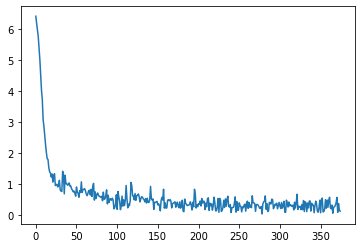

In [24]:
from matplotlib.pyplot import plot

plot(losses)

You have successfully trained your model to help automatically answer questions! Try asking it a question about a story.

In [25]:
question, text = 'What is south of the bedroom?','The hallway is south of the garden. The garden is south of the bedroom.'
input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
print(question, answer.capitalize())

What is south of the bedroom? Garden


Congratulations! You just implemented your first QA model in TensorFlow. 

<a name='2-1'></a>
## 2.2 PyTorch implementation

[PyTorch](https://pytorch.org/) is an open source machine learning framework developed by Facebook's AI Research lab that can be used for computer vision and natural language processing. As you can imagine, it is quite compatible with the bAbI dataset.

#### Train and test dataset

Go ahead and try creating a train and test dataset by importing PyTorch.

In [26]:
from torch.utils.data import DataLoader

columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']
train_ds.set_format(type='pt', columns=columns_to_return)
test_ds.set_format(type='pt', columns=columns_to_return)

For the accuracy metrics for the PyTorch implementation, you will change things up a bit and use the [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) for start and end indicies over the entire test dataset as the loss functions. 

In [27]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    start_labels = pred.label_ids[0]
    start_preds = pred.predictions[0].argmax(-1)
    end_labels = pred.label_ids[1]
    end_preds = pred.predictions[1].argmax(-1)
    
    f1_start = f1_score(start_labels, start_preds, average='macro')
    f1_end = f1_score(end_labels, end_preds, average='macro')
    
    return {
        'f1_start': f1_start,
        'f1_end': f1_end,
    }

#### Training

Now it is time to load a pre-trained model. 

**Note:** You will be using the DistilBERT instead of TFDistilBERT for a PyTorch implementation.

In [28]:
del model # We delete the tensorflow model to avoid memory issues

In [29]:
from transformers import DistilBertForQuestionAnswering

pytorch_model = DistilBertForQuestionAnswering.from_pretrained("model/pytorch")

Instead of a custom training loop, you will use the [🤗 Trainer](https://huggingface.co/transformers/main_classes/trainer.html), which contains a basic training loop and is fairly easy to implement in PyTorch.

In [30]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='results',          # output directory
    overwrite_output_dir=True,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=20,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir=None,            # directory for storing logs
    logging_steps=50
)

trainer = Trainer(
    model=pytorch_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_ds,         # training dataset
    eval_dataset=test_ds,
    compute_metrics=compute_metrics             # evaluation dataset
)

trainer.train()

Step,Training Loss
50,1.553700
100,0.783700
150,0.601800
200,0.435200
250,0.358600
300,0.295800
350,0.413400


TrainOutput(global_step=375, training_loss=0.6163130976359049, metrics={'train_runtime': 14.4753, 'train_samples_per_second': 25.906, 'total_flos': 31058547624000, 'epoch': 3.0})

In [31]:
trainer.evaluate(test_ds)

{'eval_loss': 0.32361623644828796,
 'eval_f1_start': 0.7895575553055868,
 'eval_f1_end': 0.7883126550868487,
 'eval_runtime': 2.1614,
 'eval_samples_per_second': 462.659,
 'epoch': 3.0}

Now it is time to ask your PyTorch model a question! 
* Before testing your model with a question, you can tell PyTorch to send your model and inputs to the GPU if your machine has one, or the CPU if it does not. 
* You can then proceed to tokenize your input and create PyTorch tensors and send them to your device. 
* The rest of the pipeline is relatively similar to the one you implemented for TensorFlow.   


In [32]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pytorch_model.to(device)

question, text = 'What is east of the hallway?','The kitchen is east of the hallway. The garden is south of the bedroom.'

input_dict = tokenizer(text, question, return_tensors='pt')

input_ids = input_dict['input_ids'].to(device)
attention_mask = input_dict['attention_mask'].to(device)

outputs = pytorch_model(input_ids, attention_mask=attention_mask)

start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[torch.argmax(start_logits, 1)[0] : torch.argmax(end_logits, 1)[0]+1])

print(question, answer.capitalize())

What is east of the hallway? Kitchen


### Congratulations!
 
You've completed this notebook, and can now implement Transformer models for QA tasks!

You are now able to:
* Perform extractive Question Answering 
* Fine-tune a pre-trained transformer model to a custom dataset
* Implement a QA model in TensorFlow and PyTorch

<font color='blue'><b>What you should remember</b>:
- Transformer models are often trained by tokenizers that split words into subwords.
  - Before processing, it is important that you align the start and end indices with the tokens associated with the target answer word.
- PyTorch is a relatively light and easy to implement framework that can make rapid prototyping easier, while TensorFlow has advantages in scaling and is more widely used in production
  - `tf.GradientTape` allows you to build custom training loops in TensorFlow
  - The `Trainer` API in PyTorch gives you a basic training loop that is compatible with 🤗 models and datasets

In [33]:
%%javascript
let element = document.getElementById('submit-notebook-button-group');
if (!element) {
    window._save_and_close = function(){
        IPython.notebook.save_checkpoint();
        IPython.notebook.session.delete();
        window.onbeforeunload = null
        setTimeout(function() {window.close();}, 1000)
    }
    let header = document.getElementById('maintoolbar-container');
    element = document.createElement("div");
    element.setAttribute("class", "btn-group");
    element.setAttribute("id", "submit-notebook-button-group");
    element.setAttribute("align", "right");
    element.setAttribute("style", "float:right")
    element.innerHTML = '<button class="btn btn-default" title="Save and close this notebook." style="background-color:rgb(42, 115, 204); color:white; padding:4px 8px" onclick=window._save_and_close()>Save and close</button>'
    header.appendChild(element); 
}                    

<IPython.core.display.Javascript object>